# NYPD-Complaints-Analysis

**Ge Gao & Zhaoyi Yu**

## Summary of Findings


### Introduction
- Following project 3, we continued study about the dataframe of NYPD, which contains information on more than 12,000 civilian complaints filed against New York City police officers. We aim to figure out a way to predict whether the civilian alleged did happen or not using the methods we learned from lecture. 

### Prediction
- We want to predict whether the civilian alleged did happen or not because it's significangt in reflecting whether an officer is innocent. Looking at the outcome in the column of board_disposition, we see many types of substantiation, exoneration, and unsubstantiation. For those substantiated allegatoins, there are different discriptions such as charges and Formalized Training. Therefore, we decide to put all the types of substantiation together, because they all means that the civilians alleged did happen. Also, for exonerate cases, we treat them as happened, because exoneration means that the allegation did happen but didn't violate the law. Then we will get two unique outcomes: happened or not happened. 

- The outcome of our prediction will be classifier. Since there are two possible results, it's a binary classification problem.

- We will use Accuracy as our evaluation metric in our model, because our classes is balanced. As we see, there are 15448 unsubtantiate cases, and only 17910 substantiated cases. We just want to know how many prediction is correct, and there is no major downside to predicting false negatives. 

- There are some features that we cannot use, for example, rank_abbrev_now, month_closed and year_closed, because these information we only know after the case is finalized. 

### Baseline Model
- The feateures that we want to use to predict the outcome will include mos_age_incident, complainant_gender, mos_gender, complainant_age_incident, fado_type. We use these variables because they might be related to the outcome.We impute the null values in these columns by column mean and highest frequent value within each column.
- mos_age_incident and complainant_age_incident are qunatitative variables. We didn't encode them in baseline model. 
- fado_type, complainant_gender, mos_gender are categorical variables. (All nominal) We just use one-hot encoding. 
- The accuracy for our prediction on unseen data is 58.60%, which is not good enough. We want to improve it. 


### Final Model
- For our final model, we added two new features from the original dataframe: outcome_description and rank_incident. The reason is that the distribution of outcome_description and rank_incident are both slightly different for different board_disposition. So these two features might be significant in predicting the board_disposition.
- We also improve the model by eliminate impossible age(under zero) and standardize the age of mos and complainant. Then we generate a new column which is 'same_gender', representing that whether police and complianant have the same gender. That might help because officers might or might not treat people that have the same gender as them differently, which might correlates to the substaintiation of each case. 
- We choose Decision Tree classifier as our model, and use grid search to get the best parameter for our model: max_depth = 5, and min_sample_split = 7. 
- We improve our model by approximately 4%.


### Fairness Analysis
- For our fairness evaluation, we choose the column `mos_gender`. We want to know does our model perform the same for individuals in female mos and for individuals in male mos?  We set alpha = 0.05. 
- We will use precision as our measurement. Because we really don't want false positive which will lead to injustice in this case.
- Null hypothesis: Our model is fair. Its precision for female police and male police are roughly the same, and any differences are due to random chance.
- Alternative Hypothesis: Our model is unfair. Its precision for female police is lower than its precision for male police.
- The p-value we get is 0.07, which is larger than alpha. So we fail to reject the null hypothesis. Our model likely achieves precision parity.


## Code

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [70]:
# import all the packages we need
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Binarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

### Baseline Model

We develop a baseline model for some features.

In [71]:
# read the data
df = pd.read_csv('allegations.csv')
original = df.copy()
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [72]:
#basic data cleaning
df['complainant_ethnicity'] = df['complainant_ethnicity'].replace({'Unknown': np.NaN, 'Refused': np.NaN})
df['complainant_gender']= df['complainant_gender'].apply(lambda x: np.nan if (x == 'Gender non-conforming') else x)
df['complainant_gender']= df['complainant_gender'].apply(lambda x: np.nan if (x == 'Not described') else x)
df['complainant_gender'] = df['complainant_gender'].replace({'Transman (FTM)': 'Male','Transwoman (MTF)': 'Female'})
df['mos_gender'] = df['mos_gender'].replace({'M': 'Male','F': 'Female'})

In [73]:
# we clean the outcomes of allegation, change the unique outcomes to two
df['board_disposition'] = df['board_disposition'].str.contains('Unsubstantiated')
#True for happened, False for not happended
df['board_disposition'] = df['board_disposition'].replace({True: False, False: True})
#data after basic cleaning
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,True
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,True
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,True
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,True
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,True


In [74]:
# we can see that the distribution is balanced. So we choose accuracy as out statistics.
df['board_disposition'].value_counts()

True     17910
False    15448
Name: board_disposition, dtype: int64

## First, we select few useful variables in our table that may help our predictions.
- `fado_type` may be helpful: There might be certain types of the allegations that happen most common. So including `fado_type` might be significant in finding the certain types allegations did happen or not.
- `complainant_gender` and `mos_gender` may also be helpful since it's possible that female officers or male officers might be more likely to make mistakes. Also female complainant might be more likely to report allegation that did happened since female could suffer from gender discrimination more.
- `mos_age_incident` and `complainant_age_incident` are included because maybe younger officers are more likely to make mistakes so their cases are more likely to be substantiated. 

In [75]:
# we extract the features column that we need
features_df = df[['fado_type',
                  'complainant_gender',
                  'mos_gender',
                  'mos_age_incident',
                  'complainant_age_incident',
                  'board_disposition']]
# check if board_disposition contains any na
features_df.columns[features_df.isna().any()].tolist()

['complainant_gender', 'complainant_age_incident']

##### Here we see board_disposition doesn't contain any null value in the outcome column, but there are other feature contains. We will deal with them later.

In [76]:
# we will perform train test split.
X = features_df.drop('board_disposition', axis = 1)
y = features_df['board_disposition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


### Baseline Model
##### We need to deal with missing values in the features. Here we perform imputation using SimpleImputer from sklearn, then we perform some basic onehot encoding.

In [77]:
#categorical feature, we fill in with the most frequent one
features_cat = ['complainant_gender']
imp1 = SimpleImputer(strategy='most_frequent')
pl1 = Pipeline(steps = [
    ('fill_missing', imp1),
    ('oh', OneHotEncoder())
])

#numerical feature, we fill in with the mean
features_num = ['complainant_age_incident']
imp2 = SimpleImputer(strategy='mean')
pl2 = Pipeline(steps = [
    ('fill_missing', imp2)
])

#one hot encoding for categorical features
features_oh = ['fado_type','mos_gender']
pl3 = Pipeline(steps = [
    ('oh', OneHotEncoder())
])

trans1 = ColumnTransformer(
    transformers = [
        ('cat1', pl1, features_cat),
        ('cat2', pl2, features_num),
        ('cat3', pl3, features_oh)], remainder = 'passthrough'
)

result_pl1 = Pipeline([
    ('col_trans', trans1),
    ("classifier", DecisionTreeClassifier())
])

In [78]:
# fit 
result_pl1.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat1',
                                                  Pipeline(steps=[('fill_missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                                                  ['complainant_gender']),
                                                 ('cat2',
                                                  Pipeline(steps=[('fill_missing',
                                                                   SimpleImputer())]),
                                                  ['complainant_age_incident']),
                                                 ('cat3',
                                                  Pipeline

In [79]:
# Model to predict the test
pred_test = result_pl1.predict(X_test)
pred_test
pred_train = result_pl1.predict(X_train)


In [80]:
# Model accuracy in our train set
metrics.accuracy_score(y_train, pred_train)

0.7326338329764454

In [81]:
# Model accuracy in our test set
metrics.accuracy_score(y_test, pred_test)

0.5860311750599521

The accuracy for train data is around 73.3%. For test data is around 58.6%, so we are underfitting. The baseline model is not good enough, as we only predict correctly for 6 times out of 10 for unseend data.
So we continue to improve it.

### Second Model
##### Because we are underfitting, we re-exam the data. We found that maybe outcome_description and rank_incident can be useful features because it is related to the outcome.

<AxesSubplot:xlabel='rank_incident', ylabel='count'>

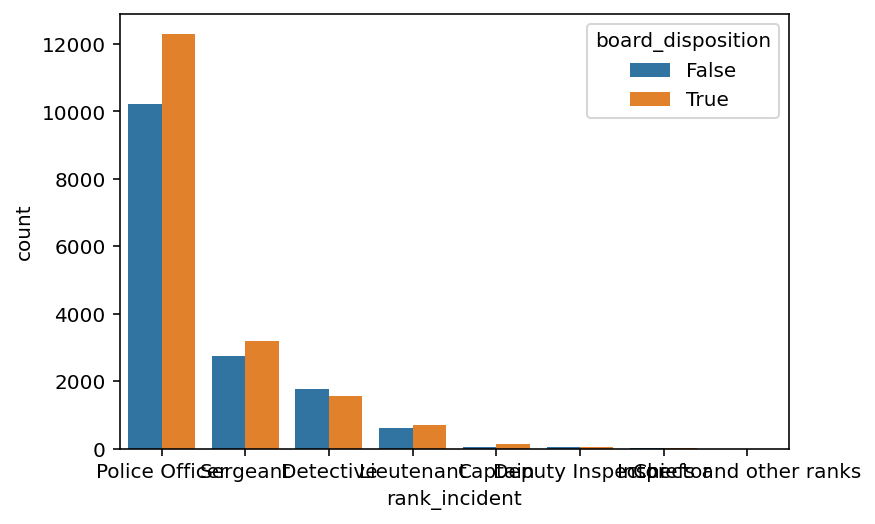

In [82]:
# We check the distrbiution of rank_incident, and we see that there are slightly different for different board_disposition
# Maybe we can add this feature to improve our model. 
sns.countplot(x="rank_incident",hue = 'board_disposition',data=df)

In [83]:
# We check another feature : outcome_description, which is how the complainant descirbe the case. And we use pivot table
# to see the distribution. It's seems that the distribution for true and false board_disposition is different. Maybe we can
# add it to model to improve the score.
pd.pivot_table(df, index = 'board_disposition', columns = 'outcome_description', aggfunc = 'count')

allegation                                  \
outcome_description Arrest - OGA Arrest - assault (against a PO)   
board_disposition                                                  
False                      293.0                           371.0   
True                       356.0                           481.0   

                                                 \
outcome_description Arrest - disorderly conduct   
board_disposition                                 
False                                     455.0   
True                                      558.0   

                                                         \
outcome_description Arrest - harrassment (against a PO)   
board_disposition                                         
False                                               6.0   
True                                                9.0   

                                                                              \
outcome_description Arrest - other violation/crime Arrest - resisting arrest   
board_disposition                                                              
False                                       4931.0                     679.0   
True                                        5265.0                     914.0   

                                                             \
outcome_description Arrest on Other Charge Assault/Arrested   
board_disposition                                             
False                                 60.0             25.0   
True                                  21.0              9.0   

                                                    \
outcome_description Disorderly-Conduct/Arr/Summons   
board_disposition                                    
False                                         85.0   
True                                          52.0   

                                                  ...  \
outcome_description Harrassment/Arrested/Summons  ...   
board_disposition                                 ...   
False                                        3.0  ...   
True                                         5.0  ...   

                                   year_received  \
outcome_description Obstruct-Govt-Admin/Arrested   
board_disposition                                  
False                                        7.0   
True                                         3.0   

                                                     \
outcome_description Other Summons Claimed or Issued   
board_disposition                                     
False                                          19.0   
True                                           19.0   

                                                                               \
outcome_description Other VTL violation summons issued Parking summons issued   
board_disposition                                                               
False                                            234.0                  131.0   
True                                             297.0                  148.0   

                                                             \
outcome_description Resisting Arrest/Arrested Summons - OGA   
board_disposition                                             
False                                    16.0           NaN   
True                                      9.0           1.0   

                                                  \
outcome_description Summons - disorderly conduct   
board_disposition                                  
False                                     1031.0   
True                                      1087.0   

                                                          \
outcome_description Summons - harrassment (against a PO)   
board_disposition                                          
False                                                4.0   
True                                                 1.0   

                                  

In [84]:
# We extract the features column that we need.
features_df = df[['fado_type',
                  'complainant_gender',
                  'mos_gender',
                  'mos_age_incident',
                  'complainant_age_incident',
                  'rank_incident',
                  'outcome_description',
                  'board_disposition']]
# check if contains any na
features_df.columns[features_df.isna().any()].tolist()

['complainant_gender', 'complainant_age_incident', 'outcome_description']

In [120]:
# We will perform train test split.
X = features_df.drop('board_disposition', axis = 1)
y = features_df['board_disposition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [86]:
# For categorical features, we just fill in with the most frequent one
features_cat = ['complainant_gender','outcome_description']
imp1 = SimpleImputer(strategy='most_frequent')
pl1 = Pipeline(steps = [
    ('fill_missing', imp1),
    ('oh', OneHotEncoder())
])
# For numerical feature, we just fill in with the mean
features_num = ['complainant_age_incident']
imp2 = SimpleImputer(strategy='mean')
pl2 = Pipeline(steps = [
    ('fill_missing', imp2)
])

# one-hot encoding
features_oh = ['fado_type','mos_gender','rank_incident']
pl3 = Pipeline(steps = [
    ('oh', OneHotEncoder())
])

trans2 = ColumnTransformer(
    transformers = [
        ('cat1', pl1, features_cat),
        ('cat2', pl2, features_num),
        ('cat3', pl3, features_oh)], remainder = 'passthrough'
)
result_pl2 = Pipeline([
    ('col_trans', trans2),
    ("classifier", DecisionTreeClassifier())
])

In [87]:
# fit 
result_pl2.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat1',
                                                  Pipeline(steps=[('fill_missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                                                  ['complainant_gender',
                                                   'outcome_description']),
                                                 ('cat2',
                                                  Pipeline(steps=[('fill_missing',
                                                                   SimpleImputer())]),
                                                  ['complainant_age_incident']),
                                          

In [88]:
# Model to predict the test
pred = result_pl2.predict(X_test)
pred

array([ True,  True,  True, ..., False,  True, False])

In [89]:
# Model Accuracy in the test set
metrics.accuracy_score(y_test, pred)

0.6058153477218226

### Third model
#### Observe and manipulate numerical features: eliminate extreme values in age and use standard scalar for the age columns.

In [121]:
df[df['complainant_age_incident'] <= 0].head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
3594,14714,Osvaldo,Nunez,114 PCT,0,12410,11,2006,2,2008,...,32,Black,Male,0.0,Force,Nightstick as club (incl asp & baton),44.0,PD suspected C/V of violation/crime - street,Summons - disorderly conduct,False
4393,15684,Thomas,Leonardo,122 PCT,2977,37891,8,2017,4,2018,...,28,Asian,Female,-1.0,Abuse of Authority,Refusal to provide name/shield number,122.0,Traffic accident,No arrest made or summons issued,True
6981,18532,Michael,Windsor,DB BNHM,5648,3711,4,1999,3,2000,...,34,Black,Male,-1.0,Force,Physical force,77.0,NaN,No arrest made or summons issued,True
10274,20185,Joseph,Delre,ESS 06,4730,4196,3,2000,10,2000,...,30,NaN,Male,-4301.0,Discourtesy,Word,72.0,Other,Parking summons issued,False
17241,25326,Katrina,Forrester,NARCBBS,3529,32671,5,2015,10,2015,...,42,Black,Female,-1.0,Abuse of Authority,Refusal to show search warrant,67.0,Execution of search warrant,Arrest - other violation/crime,False


From the above dataframe, we see that there are 8 ages that are 0 or even smaller than zero. However, no one can have 
an age smaller than 0. So we should fix it to improve the score.

In [91]:
# Categorical feature, we just fill in with the most frequent one
features_cat = ['complainant_gender','outcome_description']

imp1 = SimpleImputer(strategy='most_frequent')
pl1 = Pipeline(steps = [
    ('fill_missing', imp1),
    ('oh', OneHotEncoder())
])

# Numerical feature
features_num = ['complainant_age_incident']
def change_to_null_if_under_zero(df):
    df.loc[(df['complainant_age_incident'] <= 0), 'complainant_age_incident']= np.NaN
    return df
change = FunctionTransformer(change_to_null_if_under_zero)
imp2 = SimpleImputer(strategy='mean')
pl2 = Pipeline(steps = [
    ('zero', change),
    ('fill_missing', imp2),
    ('std', StandardScaler())
])


features_oh = ['fado_type','mos_gender','rank_incident']


pl3 = Pipeline(steps = [
    ('oh', OneHotEncoder())
])

a = ['mos_age_incident']
pl4 = Pipeline(steps = [
    ('stdd', StandardScaler())
])


trans2 = ColumnTransformer(
    transformers = [
        ('cat1', pl1, features_cat),
        ('cat2', pl2, features_num),
        ('cat3', pl3, features_oh),
        ('std11',pl4, a)]
)
result_pl3 = Pipeline([
    ('col_trans', trans2),
    ("classifier", DecisionTreeClassifier())
])

In [92]:
# fit 
result_pl3.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('cat1',
                                                  Pipeline(steps=[('fill_missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                                                  ['complainant_gender',
                                                   'outcome_description']),
                                                 ('cat2',
                                                  Pipeline(steps=[('zero',
                                                                   FunctionTransformer(func=<function change_to_null_if_under_zero at 0x7fe728095af0>)),
                                                                  ('fill_missing',
                                          

In [93]:
# Model to predict the test set
pred = result_pl3.predict(X_test)
pred

array([ True,  True,  True, ..., False,  True, False])

In [94]:
#f1_score(y_test,pred,average = 'weighted')
metrics.accuracy_score(y_test, pred)

0.6071143085531575

#### Seems like it improve a little.

### Forth Model, then we try to formulate a new column: `same_gender`
#### Maybe if the mos and complainant of different gender are more likely to report successful case. 

In [95]:
# Categorical feature, we just fill in with the most frequent one
features_cat = ['complainant_gender','outcome_description']
imp1 = SimpleImputer(strategy='most_frequent')
pl1 = Pipeline(steps = [
    ('fill_missing', imp1),
    ('oh', OneHotEncoder())
])

# Numerical feature
features_num = ['complainant_age_incident']

# Define a function to transform all values smaller than zero to null
# Then impute the null
def change_to_null_if_under_zero(df):
    df.loc[(df['complainant_age_incident'] <= 0), 'complainant_age_incident']= np.NaN
    return df

change = FunctionTransformer(change_to_null_if_under_zero)
imp2 = SimpleImputer(strategy='mean')
pl2 = Pipeline(steps = [
    ('zero', change),
    ('fill_missing', imp2),
    ('std', StandardScaler())
])


features_oh = ['fado_type','mos_gender','rank_incident']
pl3 = Pipeline(steps = [
    ('oh', OneHotEncoder())
])

a = ['mos_age_incident']
pl4 = Pipeline(steps = [
    ('stdd', StandardScaler())
])


#ADD
#same categorical features
same_feat = ['complainant_gender', 'mos_gender']
def same_age(df):
    df['same_gender'] = df['complainant_gender'] == df['mos_gender']
    return df
same = FunctionTransformer(same_age)
pl5 = Pipeline(steps = [
    ('same', same),
    ('oh', OneHotEncoder())
])

trans4 = ColumnTransformer(
    transformers = [
        ('cat1', pl1, features_cat),
        ('cat2', pl2, features_num),
        ('cat3', pl3, features_oh),
        ('std11',pl4, a),
        ('same',pl5, same_feat)]
)
result_pl4 = Pipeline([
    ('col_trans', trans4),
    ("classifier", DecisionTreeClassifier())
])

In [96]:
# fit 
result_pl4.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('cat1',
                                                  Pipeline(steps=[('fill_missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                                                  ['complainant_gender',
                                                   'outcome_description']),
                                                 ('cat2',
                                                  Pipeline(steps=[('zero',
                                                                   FunctionTransformer(func=<function change_to_null_if_under_zero at 0x7fe7280959d0>)),
                                                                  ('fill_missing',
                                          

In [97]:
# Model to predict the test
pred = result_pl4.predict(X_test)
pred

array([ True,  True,  True, ..., False,  True, False])

In [98]:
# Model accuracy for the test set
metrics.accuracy_score(y_test, pred)

0.605515587529976

#### The same gender group improves a little bit. Which is not good enough.

### Final Model

#### Grid search for parameter

In [104]:
# we will perform train test split.
X = features_df.drop('board_disposition', axis = 1)
y = features_df['board_disposition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [100]:
# Use GridSearchCV to find the best hyperparameters.
hyperparameters = {
    'max_depth': [5,7,10,13,15,17,None],
    'min_samples_split': [2, 3, 5, 7, 10, 15]
}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=hyperparameters, cv = 5)
clf.fit(trans4.fit_transform(X_train), y_train)
clf.best_params_

{'max_depth': 5, 'min_samples_split': 7}

#### Final model with gridsearch parameter


In [105]:
# For categorical features, we just fill in with the most frequent one
features_cat = ['complainant_gender','outcome_description']
imp1 = SimpleImputer(strategy='most_frequent')
pl1 = Pipeline(steps = [
    ('fill_missing', imp1),
    ('oh', OneHotEncoder())
])

# Numerical feature
features_num = ['complainant_age_incident']

# Define a function to transform all values smaller than zero to null
# Then impute the null
def change_to_null_if_under_zero(df):
    df.loc[(df['complainant_age_incident'] <= 0), 'complainant_age_incident']= np.NaN
    return df

change = FunctionTransformer(change_to_null_if_under_zero)
imp2 = SimpleImputer(strategy='mean')
pl2 = Pipeline(steps = [
    ('zero', change),
    ('fill_missing', imp2),
    ('std', StandardScaler())
])


features_oh = ['fado_type','mos_gender','rank_incident']
pl3 = Pipeline(steps = [
    ('oh', OneHotEncoder())
])

a = ['mos_age_incident']
pl4 = Pipeline(steps = [
    ('stdd', StandardScaler())
])


#ADD
#same categorical features
same_feat = ['complainant_gender', 'mos_gender']
def same_age(df):
    df['same_gender'] = df['complainant_gender'] == df['mos_gender']
    return df
same = FunctionTransformer(same_age)
pl5 = Pipeline(steps = [
    ('same', same),
    ('oh', OneHotEncoder())
])

trans_final = ColumnTransformer(
    transformers = [
        ('cat1', pl1, features_cat),
        ('cat2', pl2, features_num),
        ('cat3', pl3, features_oh),
        ('std11',pl4, a),
        ('same',pl5, same_feat)]
)
result_final = Pipeline([
    ('col_trans', trans_final),
    ("classifier", DecisionTreeClassifier(max_depth = 5, min_samples_split= 7))])

In [106]:
# fit 
result_final.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('cat1',
                                                  Pipeline(steps=[('fill_missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                                                  ['complainant_gender',
                                                   'outcome_description']),
                                                 ('cat2',
                                                  Pipeline(steps=[('zero',
                                                                   FunctionTransformer(func=<function change_to_null_if_under_zero at 0x7fe729963040>)),
                                                                  ('fill_missing',
                                          

In [107]:
# Model to predict the test
pred_test = result_final.predict(X_test)
pred_train = result_final.predict(X_train)

In [108]:
# Model accuracy in the train set
metrics.accuracy_score(y_train, pred_train)

0.6241970021413277

In [109]:
# Model accuracy in the test set
metrics.accuracy_score(y_test, pred_test)

0.6214028776978417

- Therefore, we decide that our final model is the model that invovles 7 features, including 
'fado_type','complainant_gender','mos_gender','mos_age_incident','complainant_age_incident','rank_incident','outcome_description'.

- Accuracy increases from 0.58 to 0.62.(improve by about 4%). And the accuracy for train and test is approximagely the same. 
- Remark: Although we tried a lot methods of feature engineering, they cannot improve the model a lot. 

### Fairness Analysis

#### For the fairness analysis, we choose the column `mos gender`. We want to know whether our model perform the same for individuals in female mos and for individuals in male mos. 
- Null Hypothesis: Our model is fair. Its precision for female polices and male polices are roughly the same, and any differences are due to random chance.
- Alternative Hypothesis: Our model is unfair. Its precision for female polices is lower than its precision for male polices.
- Test statistic: Difference in precision (female polices minus male polices).
- Significance level: alpha = 0.05.

In [110]:
#mos_gender
df_test = X_test
df_test['board_disposition'] = y_test
df_test['predicted_outcome']= result_final.predict(df_test)
df_test.head()

,fado_type,complainant_gender,mos_gender,mos_age_incident,complainant_age_incident,rank_incident,outcome_description,board_disposition,predicted_outcome
22231,Abuse of Authority,Male,Male,27,29.0,Police Officer,Arrest - other violation/crime,True,True
18436,Abuse of Authority,Male,Male,32,17.0,Police Officer,Summons - disorderly conduct,True,True
10968,Discourtesy,Male,Male,37,15.0,Police Officer,Arrest - assault (against a PO),False,False
12391,Force,Male,Male,27,28.0,Police Officer,Arrest - other violation/crime,False,True
30948,Discourtesy,Male,Male,42,51.0,Police Officer,No arrest made or summons issued,False,False


In [113]:
# Observe statistics
obs = df_test.groupby('mos_gender').apply(lambda x: metrics.precision_score(x['board_disposition'], x['predicted_outcome'])).diff().iloc[-1]
obs

-0.04964392769552184

In [117]:
# We perform permutation on the dataframe df5
result = []
for i in range(1000):
    stats = (
        df_test[['mos_gender', 'predicted_outcome', 'board_disposition']]
        .assign(mos_gender=df_test.mos_gender.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('mos_gender')
        .apply(lambda x: metrics.precision_score(x['predicted_outcome'], x['board_disposition']))
        .diff()
        .iloc[-1]
    )
    
    result.append(stats)

In [118]:
pval = pd.Series(result <= obs).mean()
pval

0.07

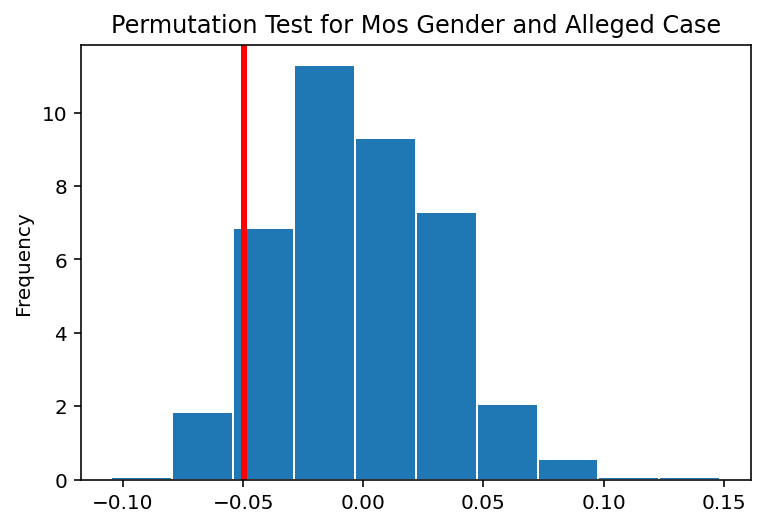

In [119]:
pd.Series(result).plot(kind='hist', density = True,ec='w', bins=10, title='Permutation Test for Mos Gender and Alleged Case')
plt.axvline(x=obs, color='red', linewidth=3);

#### Conclusion: The p-value is 0.07, which is larger than alpha 0.05. Thus, we fail to reject that prediction is "fair" among different female and male police. Our model likely achieves precision parity.